In [1]:
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase

## Build atomic potential

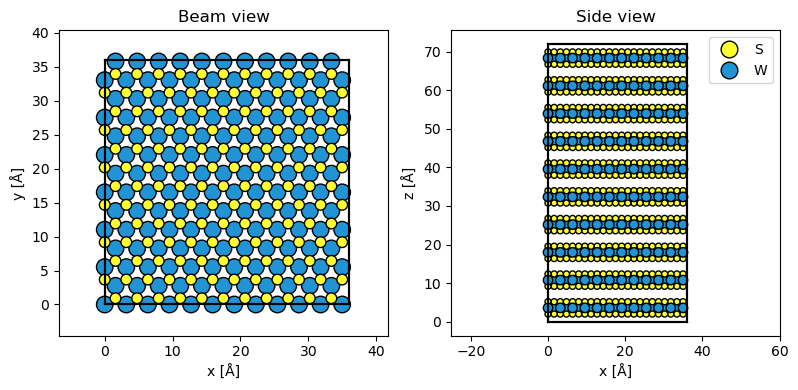

In [2]:
atoms = ase.build.mx2("WS2", vacuum=2)
atoms = abtem.orthogonalize_cell(atoms) * (14, 8, 1)
new_atoms = abtem.atoms.cut_cell(atoms, cell=[36, 36, 10*7.1899999999999995]) # crop to a square model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(new_atoms, ax=ax1, title="Beam view")
abtem.show_atoms(new_atoms, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

In [3]:
newset=new_atoms.copy()
mask1 =newset.positions[:, 2] < 66
del newset[np.where(mask1)[0]]
newset.rotate(45, "z") #rotate the layer
newset.positions[:, 0] += 12 #shift it back into the scan (x)
newset.positions[:, 1] -= 12 #shift it back into the scan (y)

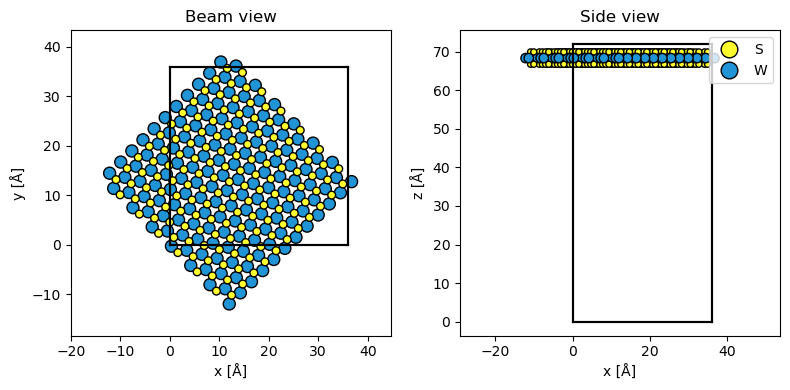

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(newset, ax=ax1, title="Beam view")
abtem.show_atoms(newset, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

In [5]:
newset2=new_atoms.copy()
mask2 =newset2.positions[:, 2] > 6
del newset2[np.where(mask2)[0]]

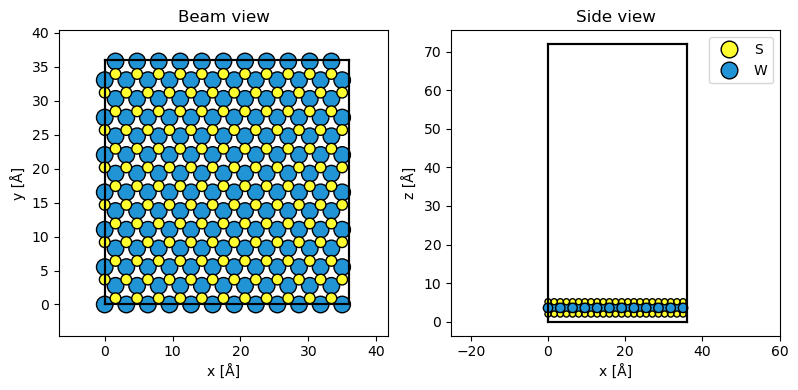

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(newset2, ax=ax1, title="Beam view")
abtem.show_atoms(newset2, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

In [7]:
bilayer=newset+newset2

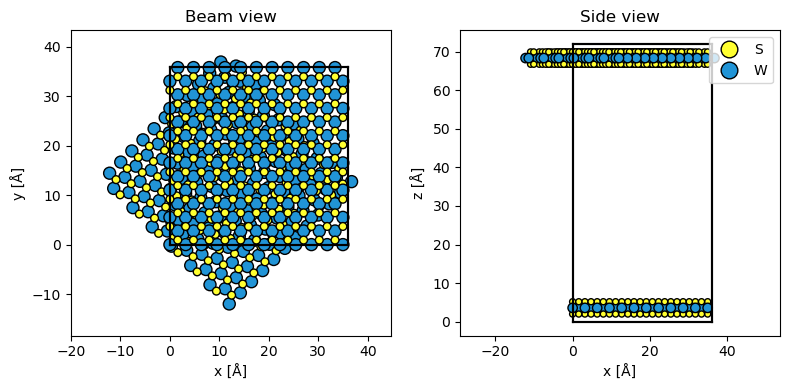

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
abtem.show_atoms(bilayer, ax=ax1, title="Beam view")
abtem.show_atoms(bilayer, plane="xz", ax=ax2, title="Side view", legend=True)
fig.tight_layout()

[########################################] | 100% Completed | 328.11 ms


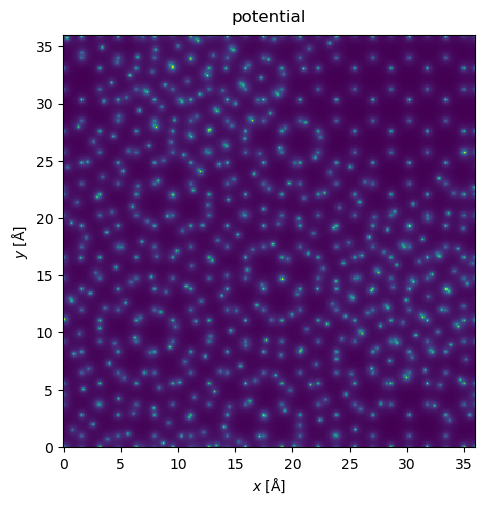

In [9]:
potential = abtem.Potential(
    bilayer,
    sampling=0.1,
    device="cpu",
    projection="infinite",
    parametrization="kirkland",
)

potential.project().show(cmap='viridis', title="potential")

## Initialize probe

[########################################] | 100% Completed | 106.02 ms


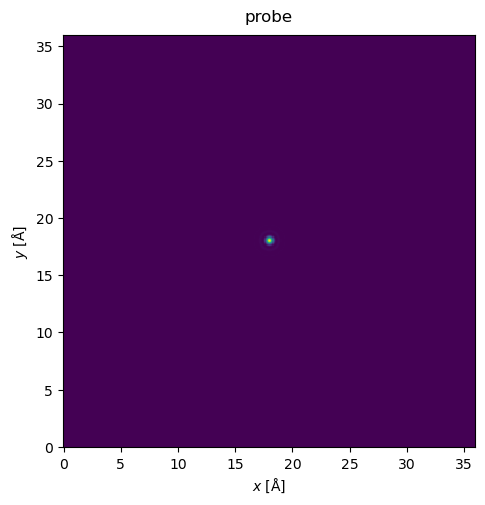

In [10]:
energy = 200e3 # voltages
semiangle_cutoff = 25 # mrad
defocus = 0 # angstrom
#aberrations = {"C10": -defocus, 
               # "C12": 8, "phi12": -0.5, 
               # "C21": 50, "phi21": 0.1,
              #  "C23": 50, "phi23": 0.4,
              #  "C30": 1e5, 
              #  "C32": 2e4, "phi32": 0.9,
              #  "C34": 2e4, "phi34": 0.4,
              # }
aberrations = {"C10": -defocus, 
               "C12": 0, "phi12": -0.5, 
               "C21": 0, "phi21": 0.1,
               "C23": 0, "phi23": 0.4,
               "C30": 0e5, 
               "C32": 0e4, "phi32": 0.9,
               "C34": 0e4, "phi34": 0.4,
              }

probe = abtem.Probe(
    semiangle_cutoff=semiangle_cutoff,
    energy=energy,
    **aberrations,
    device="cpu",
)

probe.match_grid(potential)

probe.show(cmap='viridis', title="probe")

## Grid scan simulation

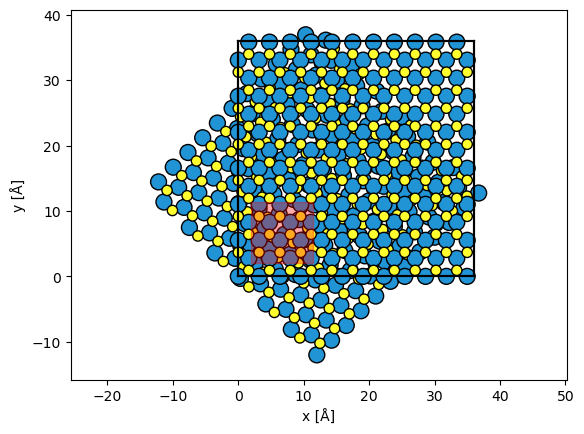

In [11]:
maximum_scattering_angle_mrad = 50 # mrad
scan_step_size = 0.24 # angstrom
scan_pixels = 39
scan_start = [2, 2]
scan_end = [scan_start[0] + scan_step_size*scan_pixels, scan_start[1] + scan_step_size*scan_pixels]

pixelated_detector = abtem.PixelatedDetector(max_angle=maximum_scattering_angle_mrad)

gridscan = abtem.GridScan(
    start=scan_start, 
    end=scan_end,
    # fractional=True,
    potential=potential,
    sampling=scan_step_size,
)

fig, ax = abtem.show_atoms(bilayer)
gridscan.add_to_plot(ax)

[########################################] | 100% Completed | 41.90 s


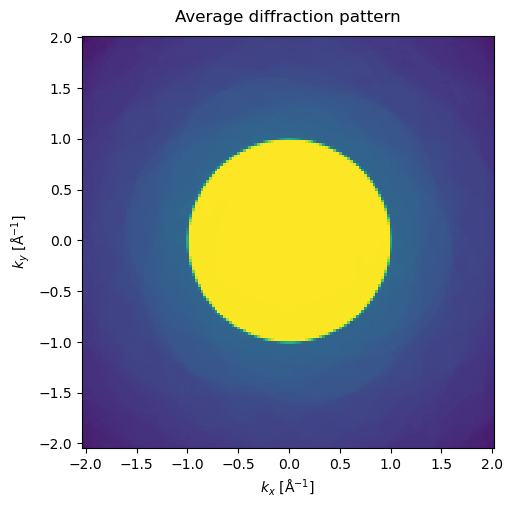

In [12]:
# Simulation
diffraction_patterns = probe.scan(potential, 
                                  scan=gridscan, 
                                  detectors=pixelated_detector,
                                  )
diffraction_patterns.compute()
diffraction_patterns.mean((0,1)).show(power=0.25, title='Average diffraction pattern', cmap='viridis')

In [14]:
# Saving dataset #uncomment below to save noise free
# data_dict = {
#     'data_4D': np.float32(diffraction_patterns.array),
#     'scan_step_size': scan_step_size,
#     'aperture_size': semiangle_cutoff/1e3,
#     'voltage': energy/1e3,
#     'dose': 'infinity'
# }
# filename = f'WS2bilayer_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_noise_free.npy'
# np.save(filename, data_dict)

## Apply Poisson noise

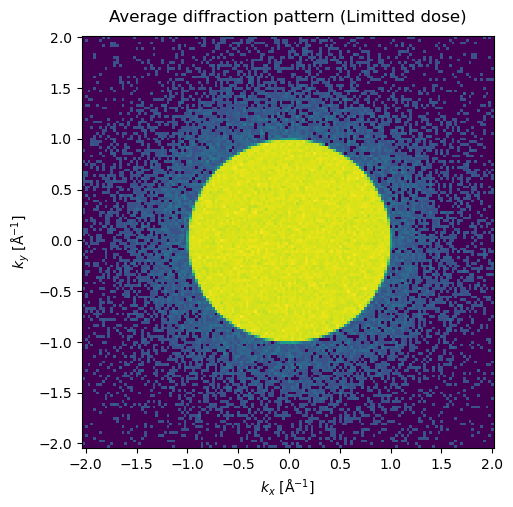

In [13]:
# Apply poisson noise
dose = 1e4 # electrons per square angstrom
measurement_noise = diffraction_patterns.poisson_noise(dose)
measurement_noise.mean((0,1)).show(power=0.25, 
                                   title='Average diffraction pattern (Limitted dose)', 
                                   cmap='viridis')
data_4D = measurement_noise.array

In [14]:
print(f'dataset size:\t {data_4D.shape}')
print(f'scan step size:\t {scan_step_size} A')
print(f'aperture size:\t {int(semiangle_cutoff)} mrad')
print(f'voltage:\t {int(energy/1000)} keV')
print(f'dose:\t\t {int(dose)} e/A^2')

dataset size:	 (39, 39, 146, 146)
scan step size:	 0.24 A
aperture size:	 25 mrad
voltage:	 200 keV
dose:		 10000 e/A^2


In [15]:
# Saving dataset
data_dict = {
    'data_4D': np.float32(measurement_noise.array),
    'scan_step_size': scan_step_size,
    'aperture_size': semiangle_cutoff/1e3,
    'voltage': energy/1e3,
    'dose': dose
}
filename = f'WS2bilayer_{int(energy/1000)}kV_{int(semiangle_cutoff)}mrad_dose_{int(dose)}.npy'
np.save(filename, data_dict)

# Single side-band (SSB) ptychography reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
#sys.path.append('/Users/test/repos/pyptychostem/') # path to pyptychostem
#sys.path.append('./pyptychostem/') # path to pyptychostem
sys.path.append('./Songge_1/') # path to pyptychostem
from STEM4D import *
%matplotlib widget

## Load dataset and set parameters

In [2]:
#filename = '../WS2_200kV_25mrad_noise_free.npy'
filename = 'WS2bilayer_200kV_25mrad_dose_10000.npy'
data = np.load(filename, allow_pickle=True).item()
parfile = {'aperture': data['aperture_size'], 
           'voltage': data['voltage'], 
           'stepsize': data['scan_step_size'], 
           'threshold': 0.2}
data_4D = Data4D(parfile, data=data['data_4D'])
data_4D.bin_Q(bin_factor=2)
data_4D.estimate_aperture_size()
data_4D.plot_4D()

{'aperture': 0.025, 'voltage': 200.0, 'stepsize': 0.24, 'threshold': 0.2}
dataset size:	 (39, 39, 73, 73)


<Signal2D, title: 4D data, dimensions: (39, 39|73, 73)>

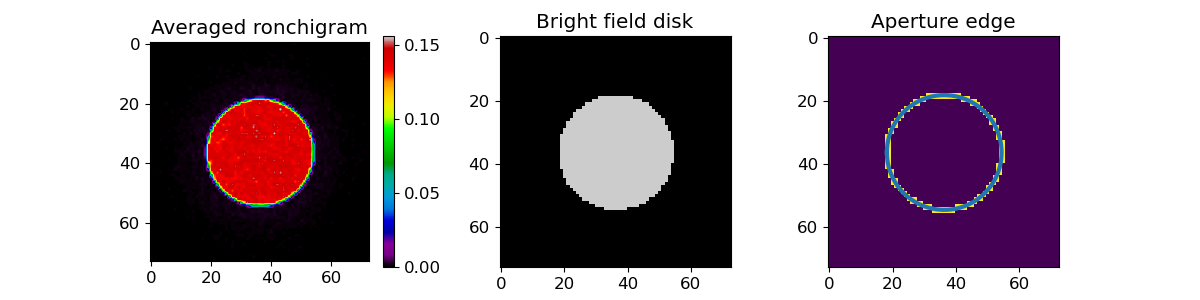

In [3]:
data_4D.plot_aperture()


## Fourier transform 4D dataset in scanning space $G(\mathbf{K_f, Q})=\mathcal{F}_{\mathbf{r}}\{I(\mathbf{K_f, r})\}$

In [4]:
data_4D.truncate_ronchigram(expansion_ratio=None) # crops ronchigram to the BF disk
data_4D.apply_FT()


In [5]:
data_4D.plot_4D_reciprocal(signal='amplitude')

<Signal2D, title: FT of 4D data, dimensions: (39, 39|73, 73)>

In [6]:
data_4D.plot_4D_reciprocal_both()

The module://ipympl.backend_nbagg matplotlib backend is not compatible with the traitsui GUI elements. For more information, read http://hyperspy.readthedocs.io/en/stable/user_guide/getting_started.html#possible-warnings-when-importing-hyperspy.


<Signal2D, title: FT of 4D data, dimensions: (39, 39, 2|73, 73)>

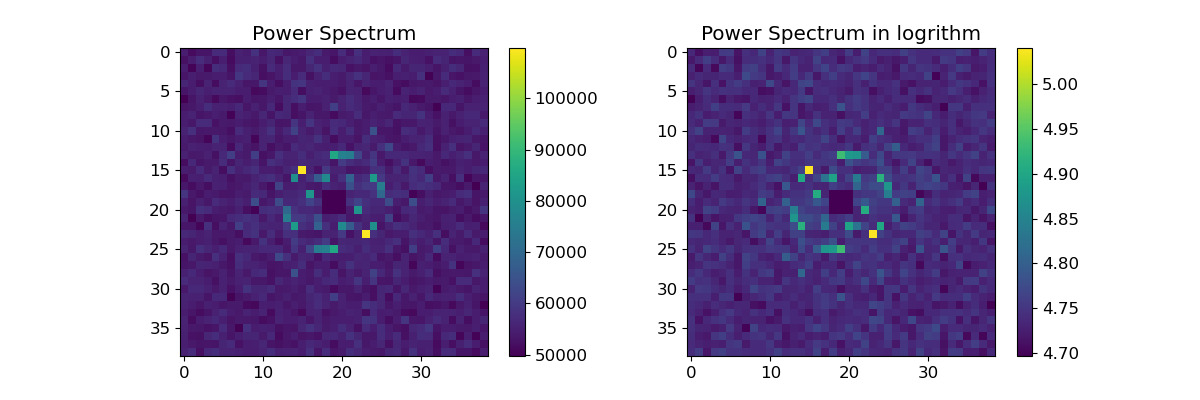

In [7]:
data_4D.remove_zero_frequency()
data_4D.plot_FT()

## Reconstruct without aberration correction

In [8]:
plt.close('all')
%matplotlib inline

In [9]:
ssb = SSB(data_4D)
ssb.run()

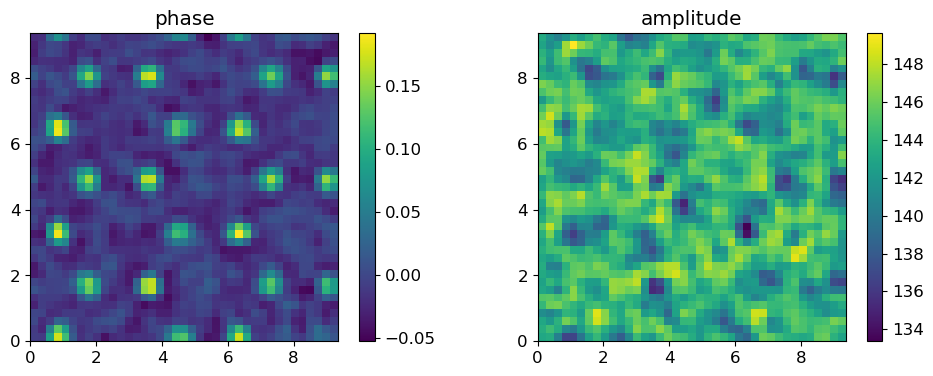

In [10]:
ssb.plot_result()

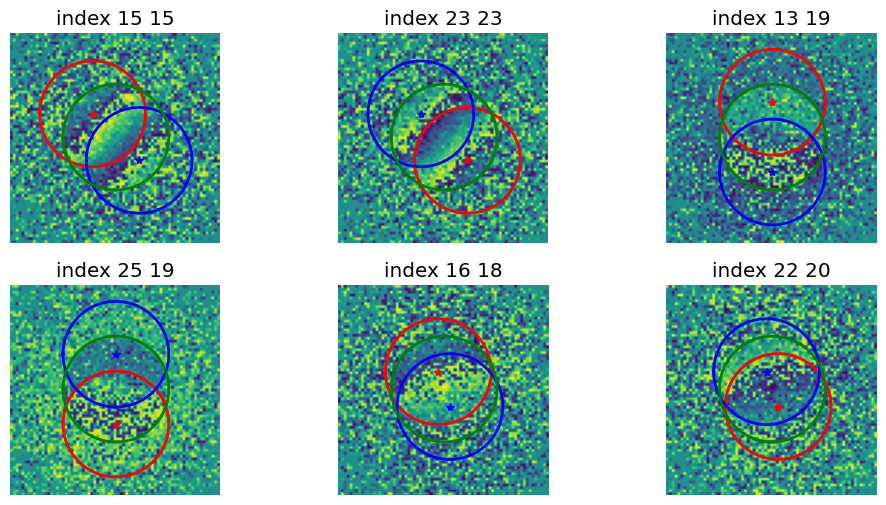

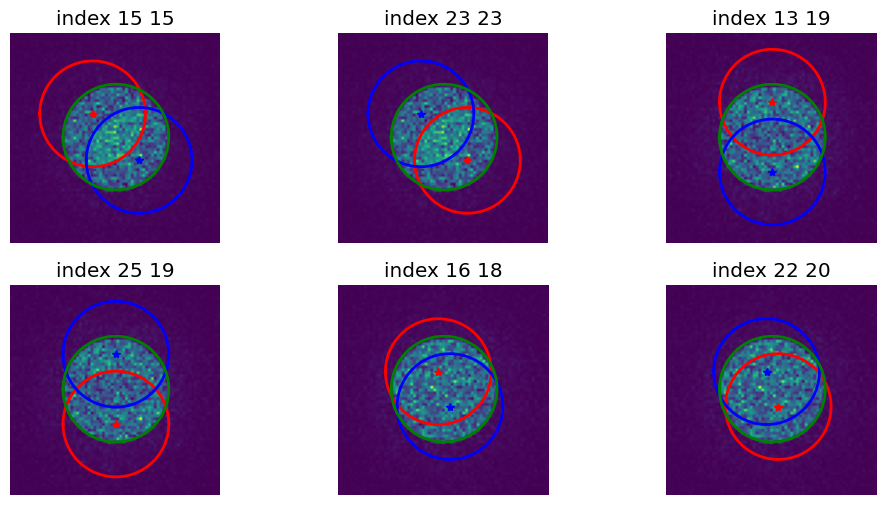

In [29]:
#data_4D.plot_trotters(rotation_angle=0,skip=1)
data_4D.plot_trotters()

In [30]:
svd = SVD_AC(data_4D, trotters_nb=6)
svd.find_trotters()

6 trotters found
trotter index: [[15, 15], [23, 23], [13, 19], [25, 19], [16, 18], [22, 20]]


In [31]:
aberration_coeffs = svd.run_svd(iterations=20, order=3, cf=0.5)
svd.print_aberration_coefficients(aberration_coeffs)

C10  =  2.11  nm
C12a =  -3.663  nm
C12b =  -0.627  nm
C21a =  -143.703  nm
C21b =  38.165  nm
C23a =  -34.675  nm
C23b =  66.586  nm
C30  =  -2.271  um
C32a =  13.757  um
C32b =  8.743  um
C34a =  2.039  um
C34b =  0.438  um
C41a =  0.0  mm
C41b =  0.0  mm
C43a =  0.0  mm
C43b =  0.0  mm
C45a =  0.0  mm
C45b =  0.0  mm
C50  =  0.0  mm
C52a =  0.0  mm
C52b =  0.0  mm
C54a =  0.0  mm
C54b =  0.0  mm
C56a =  0.0  mm
C56b =  0.0  mm


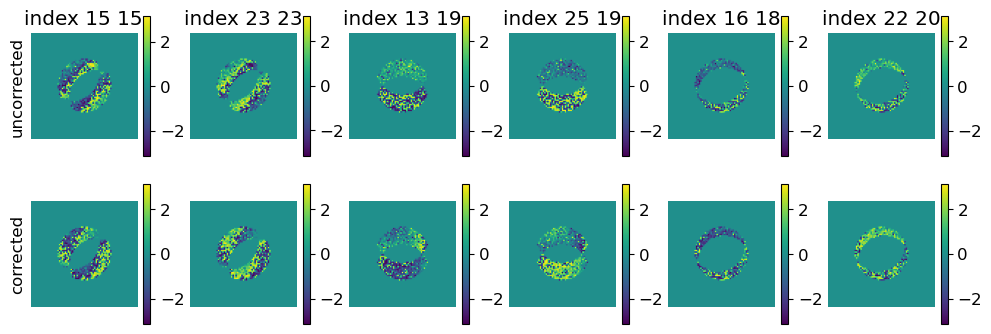

In [32]:
svd.plot_corrected_trotters(data_4D.selected_frames,svd.aberration_coeffs)

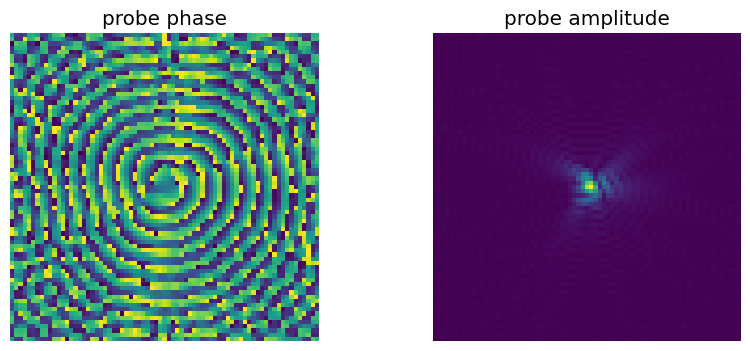

In [33]:
svd.calc_probefunction()
svd.plot_probe()

## Reconstruct using arbitrary aberration coefficients

The below cell will set the aberrations measuremnts to whatever values you want so can see the effect of adding / removing. Units are meters. Keep in mind these are counteracted so essentailly you put in the opposite value. In an aberration-corrected microscope, first orders are usually below 10 nm, second orders below 100 nm, third orders below 5 $\mu$m and higher orders below 1 mm. 

In [11]:
aberrations = [0e-9, # C10
               0, # C12a
               0, # C12b 
               0, # C23a
               0, # C23b
               0, # C21a
               0, # C21b
               0, # C3 
               0, # C34a
               0, # C34b
               0, # C32a
               0, # C32b
               0, # C45a
               0, # C45b
               0, # C43a
               0, # C43b
               0, # C41a
               0, # C41b
               0, # C5
               0, # C56a
               0, # C56b
               0, # C54a
               0, # C54b
               0, # C52a
               0, # C52b
              ]
aberrations = np.array(aberrations)
#svd.print_aberration_coefficients(aberrations)

In [12]:
ssb_ac = SSB(data_4D)
ssb_ac.run(aberrations=aberrations, order=3)

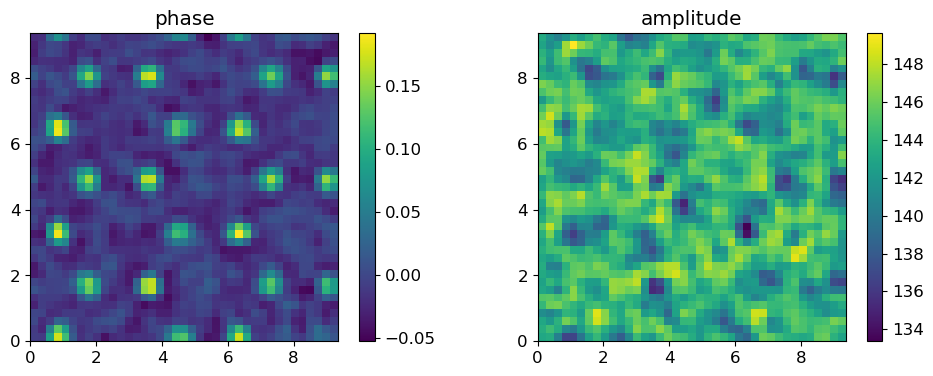

In [13]:
ssb_ac.plot_result()

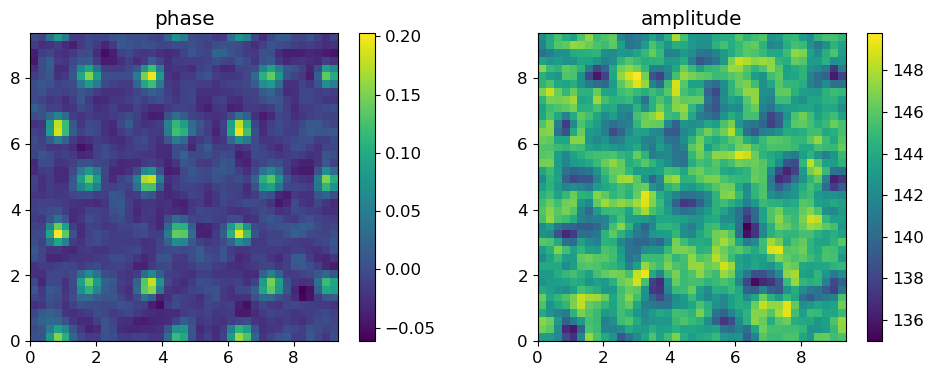

In [38]:
aberrations = [0e-9, # C10
               0, # C12a
               0, # C12b 
               0, # C23a
               0, # C23b
               0, # C21a
               0, # C21b
               0, # C3 
               0, # C34a
               0, # C34b
               0, # C32a
               0, # C32b
               0, # C45a
               0, # C45b
               0, # C43a
               0, # C43b
               0, # C41a
               0, # C41b
               0, # C5
               0, # C56a
               0, # C56b
               0, # C54a
               0, # C54b
               0, # C52a
               0, # C52b
              ]
aberrations = np.array(aberrations)
ssb_ac = SSB(data_4D)
ssb_ac.run(aberrations=aberrations, order=3)
ssb_ac.plot_result()

## Post collection defocus series

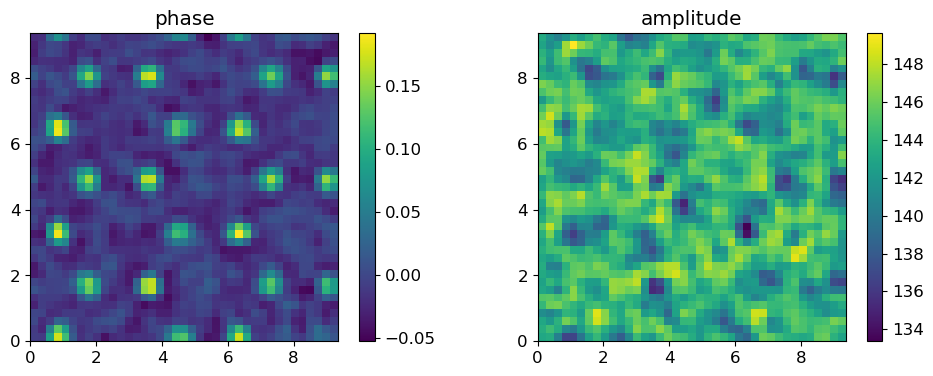

Defocus 0 nm


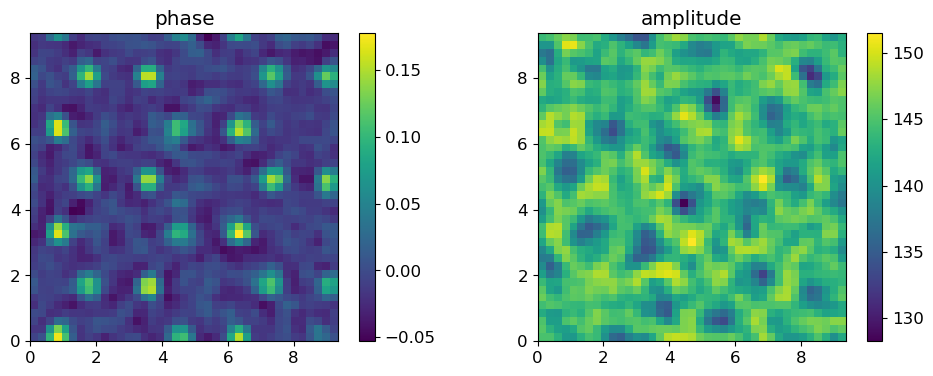

Defocus 2 nm


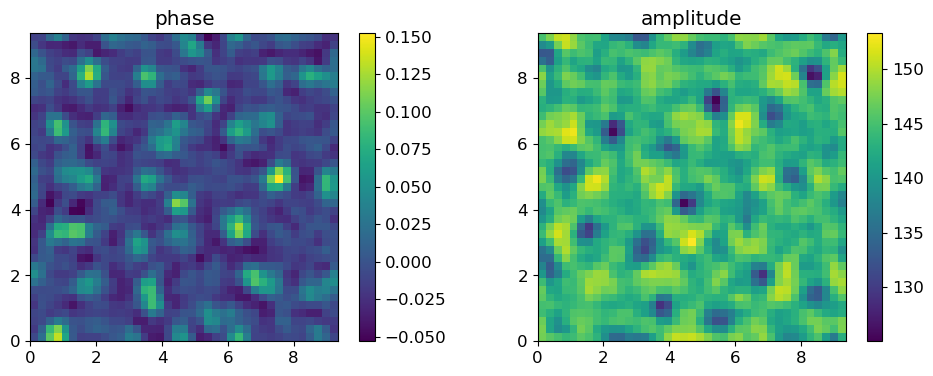

Defocus 4 nm


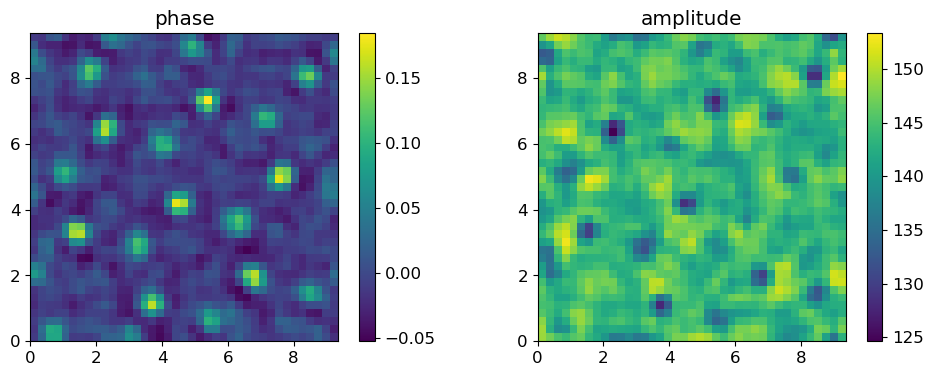

Defocus 6 nm


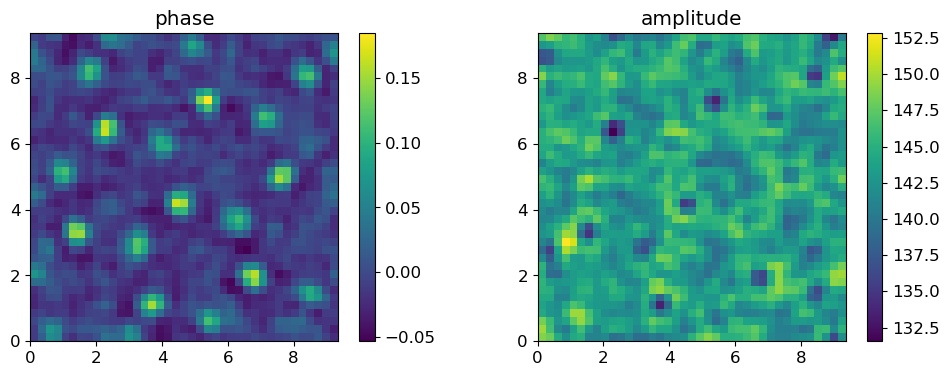

Defocus 8 nm


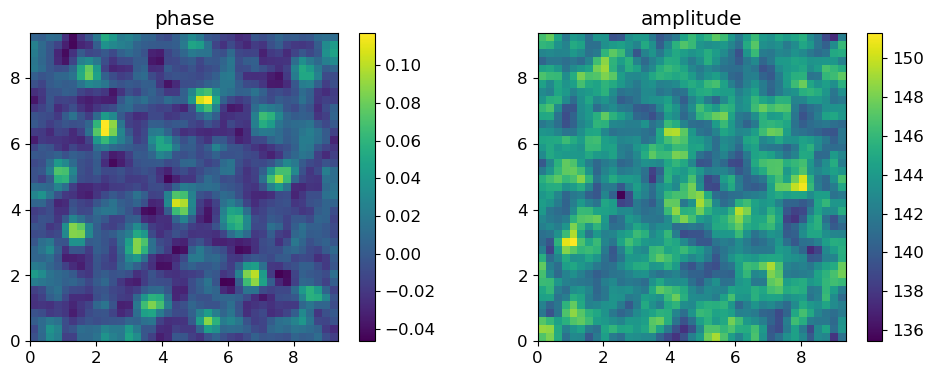

Defocus 10 nm


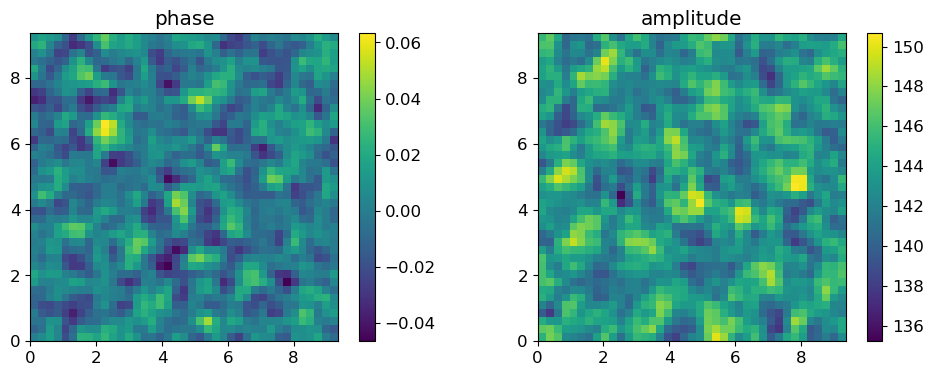

Defocus 12 nm


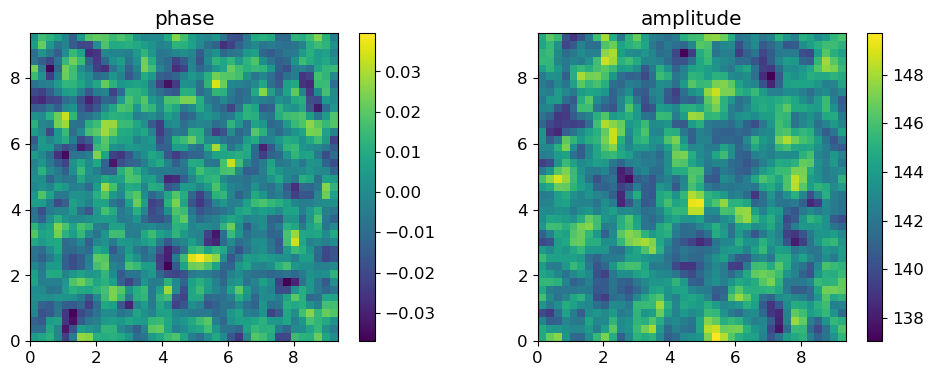

Defocus 14 nm


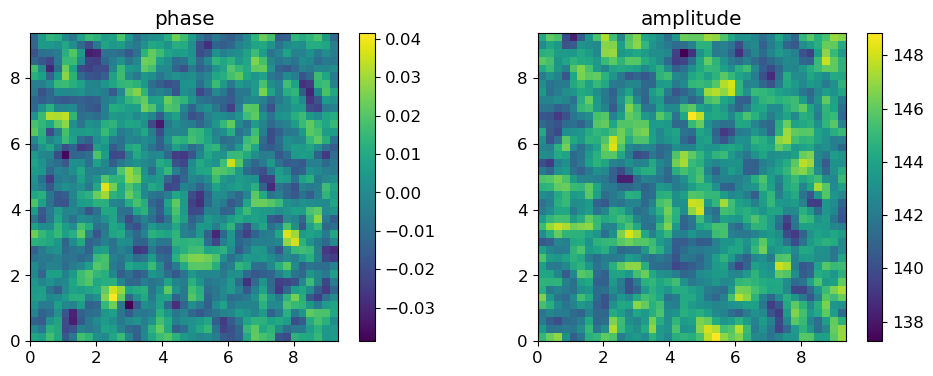

Defocus 16 nm


In [14]:
num = 0 # initialize the starting number
while num < 17: # loop as long as the number is less than 10
    aberrations = [num*1e-9, # C10
                   0, # C12a
                   0, # C12b 
                   0, # C23a
                   0, # C23b
                   0, # C21a
                   0, # C21b
                   0, # C3 
                   0, # C34a
                   0, # C34b
                   0, # C32a
                   0, # C32b
                   0, # C45a
                   0, # C45b
                   0, # C43a
                   0, # C43b
                   0, # C41a
                   0, # C41b
                   0, # C5
                   0, # C56a
                   0, # C56b
                   0, # C54a
                   0, # C54b
                   0, # C52a
                   0, # C52b
                  ]
    aberrations = np.array(aberrations)
    ssb_ac = SSB(data_4D)
    ssb_ac.run(aberrations=aberrations, order=3)
    ssb_ac.plot_result()
    print('Defocus',num,'nm')
    num += 2 # increase the number by 2 for each iteration